In [1]:
# Cell [1]
import os
import time
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import timm
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [2]:
# Cell [2]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [3]:
# Cell [3]
data_dir = r'C:\Users\heman\Desktop\Transfer\Project\DataSets\osteoathritis(1)'  # Replace with your dataset directory path
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'validation')
test_dir = os.path.join(data_dir, 'test')


In [4]:
# Cell [3.5] (New cell before data_transforms)
from torch.utils.data import DataLoader

def compute_mean_std(dataset):
    loader = DataLoader(dataset, batch_size=64, num_workers=0)
    mean = 0.0
    var = 0.0
    total_samples = 0
    
    for images, _ in loader:
        batch_size = images.size(0)
        images = images.view(batch_size, images.size(1), -1)
        mean += images.mean(2).sum(0)
        var += images.var(2).sum(0)
        total_samples += batch_size
    
    mean /= total_samples
    var /= total_samples
    std = torch.sqrt(var)
    return mean, std

# Create a temporary dataset without normalization to compute mean and std
input_size = 224  # ConvNeXt default input size

temp_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

temp_dataset = datasets.ImageFolder(train_dir, transform=temp_transforms)
mean, std = compute_mean_std(temp_dataset)
print(f"Computed mean: {mean.item():.4f}, std: {std.item():.4f}")


Computed mean: 0.6062, std: 0.1614


In [5]:
# Cell [4] (Modified)
# Make sure that input_size, mean, and std are defined in your notebook prior to this cell.
# For example:
# input_size = 224
# mean = torch.tensor(0.5)    # Example value
# std = torch.tensor(0.25)    # Example value

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.RandomHorizontalFlip(),  # Flip horizontally with probability=0.5
        
        # Apply a small random rotation (±10°)
        transforms.RandomRotation(degrees=10, fill=(0,)),
        
        # Apply a random affine transformation with slight translation and scaling
        transforms.RandomAffine(
            degrees=0, 
            translate=(0.05, 0.05),  # Translation: up to 5% in x and y direction
            scale=(0.95, 1.05),      # Scale variation: ±5%
            fill=0
        ),
        
        # Optionally, apply slight brightness/contrast adjustments with a probability of 30%
        transforms.RandomApply([
            transforms.ColorJitter(brightness=0.1, contrast=0.1)
        ], p=0.3),
        
        transforms.Grayscale(num_output_channels=1),  # Convert images to grayscale
        transforms.ToTensor(),
        transforms.Normalize([mean.item()], [std.item()])
    ]),
    
    'validation': transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize([mean.item()], [std.item()])
    ]),
    
    'test': transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize([mean.item()], [std.item()])
    ]),
}


In [6]:
# Cell [5]
image_datasets = {
    'train': datasets.ImageFolder(train_dir, transform=data_transforms['train']),
    'validation': datasets.ImageFolder(val_dir, transform=data_transforms['validation']),
    'test': datasets.ImageFolder(test_dir, transform=data_transforms['test'])
}

dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=0),
    'validation': DataLoader(image_datasets['validation'], batch_size=32, shuffle=False, num_workers=0),
    'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=False, num_workers=0)
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation', 'test']}
class_names = image_datasets['train'].classes
num_classes = len(class_names)

print(f"Classes: {class_names}")

# Cell [5 continued]

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
print(f"Input batch shape: {inputs.shape}")  # Should be [batch_size, 1, 224, 224]


Classes: ['0', '1', '2', '3', '4']
Input batch shape: torch.Size([32, 1, 224, 224])


In [7]:
# Cell [6]
from collections import Counter

def count_images_per_class(dataset):
    class_counts = Counter()
    for path, label in dataset.samples:
        class_name = dataset.classes[label]
        class_counts[class_name] += 1
    return class_counts

print("Number of images per class in each dataset:")

for phase in ['train', 'validation', 'test']:
    counts = count_images_per_class(image_datasets[phase])
    print(f"\n{phase.capitalize()} Dataset:")
    for class_name in class_names:
        print(f"  {class_name}: {counts[class_name]} images")


Number of images per class in each dataset:

Train Dataset:
  0: 2286 images
  1: 1056 images
  2: 1516 images
  3: 757 images
  4: 173 images

Validation Dataset:
  0: 328 images
  1: 153 images
  2: 212 images
  3: 106 images
  4: 27 images

Test Dataset:
  0: 639 images
  1: 296 images
  2: 447 images
  3: 223 images
  4: 51 images


In [8]:
# Cell [7]

# Load ConvNeXt model with adjusted input channels and number of classes
model = timm.create_model('convnext_base', pretrained=True, in_chans=1, num_classes=num_classes)

# Remove manual replacement of the classifier head
# model.head = nn.Linear(model.head.in_features, num_classes)  # Remove this line

model = model.to(device)


In [9]:
# Cell [8] (Modified)
num_epochs = 20
criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)


In [10]:
# Cell [9] (Modified)
import copy

def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []
    
    for epoch in range(num_epochs):
        epoch_start = time.time()
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()  # Training mode
            else:
                model.eval()   # Evaluation mode
                
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                train_acc_history.append(epoch_acc.cpu())
                train_loss_history.append(epoch_loss)
            else:
                val_acc_history.append(epoch_acc.cpu())
                val_loss_history.append(epoch_loss)
                
                # Check if this is the best model so far
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    print(f'New best model found at epoch {epoch+1} with validation accuracy: {best_acc:.4f}')
            
            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
        epoch_end = time.time()
        epoch_duration = epoch_end - epoch_start
        remaining_time = (num_epochs - (epoch+1)) * epoch_duration
        print(f'Epoch duration: {epoch_duration//60:.0f}m {epoch_duration%60:.0f}s')
        print(f'Estimated time remaining: {remaining_time//60:.0f}m {remaining_time%60:.0f}s\n')
        
    total_time = time.time() - since
    print(f'Training complete in {total_time//60:.0f}m {total_time%60:.0f}s')
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    print(f'Best validation accuracy: {best_acc:.4f}')
    
    return model, train_acc_history, val_acc_history, train_loss_history, val_loss_history


In [11]:
# Cell [10]
num_epochs = 20  # Adjust as needed
model, train_acc_history, val_acc_history, train_loss_history, val_loss_history = train_model(
    model, criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/20
----------
Train Loss: 1.0747 Acc: 0.5456
New best model found at epoch 1 with validation accuracy: 0.6308
Validation Loss: 0.8706 Acc: 0.6308
Epoch duration: 41m 40s
Estimated time remaining: 791m 38s

Epoch 2/20
----------
Train Loss: 0.8056 Acc: 0.6614
New best model found at epoch 2 with validation accuracy: 0.6743
Validation Loss: 0.7735 Acc: 0.6743
Epoch duration: 43m 26s
Estimated time remaining: 781m 42s

Epoch 3/20
----------
Train Loss: 0.7320 Acc: 0.6935
New best model found at epoch 3 with validation accuracy: 0.6889
Validation Loss: 0.7239 Acc: 0.6889
Epoch duration: 43m 33s
Estimated time remaining: 740m 22s

Epoch 4/20
----------
Train Loss: 0.6823 Acc: 0.7085
New best model found at epoch 4 with validation accuracy: 0.7010
Validation Loss: 0.7414 Acc: 0.7010
Epoch duration: 41m 5s
Estimated time remaining: 657m 18s

Epoch 5/20
----------
Train Loss: 0.6372 Acc: 0.7286
Validation Loss: 0.8102 Acc: 0.6816
Epoch duration: 39m 15s
Estimated time remaining: 588m 3

In [12]:
# Cell [11] (Modified)
save_directory = r'C:\Users\heman\Desktop\Transfer\Project\Models\CovNeXt'  # Replace with your desired save directory
os.makedirs(save_directory, exist_ok=True)
model_path = os.path.join(save_directory, 'convnext_knee_xray_03.pth')
torch.save(model.state_dict(), model_path)
print(f"Best model saved to {model_path}")


Best model saved to C:\Users\heman\Desktop\Transfer\Project\Models\CovNeXt\convnext_knee_xray_03.pth


In [13]:
# Cell [12]
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())


In [14]:
# Cell [13]
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"F1 Score: {f1*100:.2f}%")
# Cell [14]
report = classification_report(y_true, y_pred, target_names=class_names, zero_division=0)
print("Classification Report:")
print(report)


Accuracy: 71.26%
Precision: 71.56%
Recall: 69.94%
F1 Score: 69.38%
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.91      0.81       639
           1       0.43      0.17      0.24       296
           2       0.68      0.73      0.70       447
           3       0.82      0.78      0.80       223
           4       0.92      0.90      0.91        51

    accuracy                           0.71      1656
   macro avg       0.72      0.70      0.69      1656
weighted avg       0.68      0.71      0.68      1656



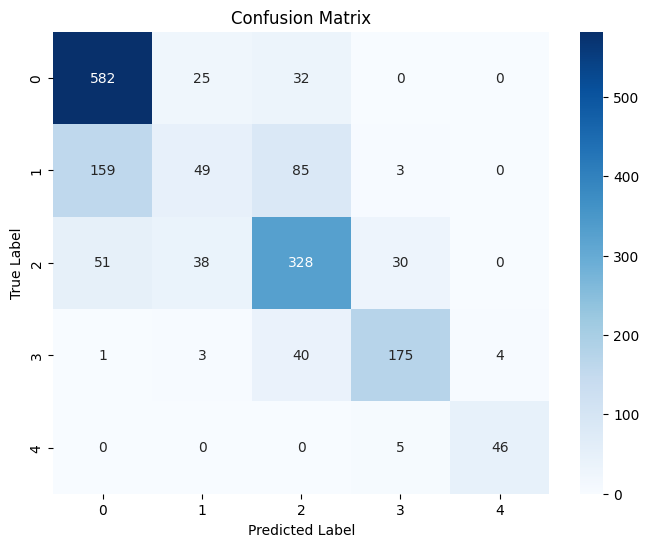

In [15]:
# Cell [15]
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


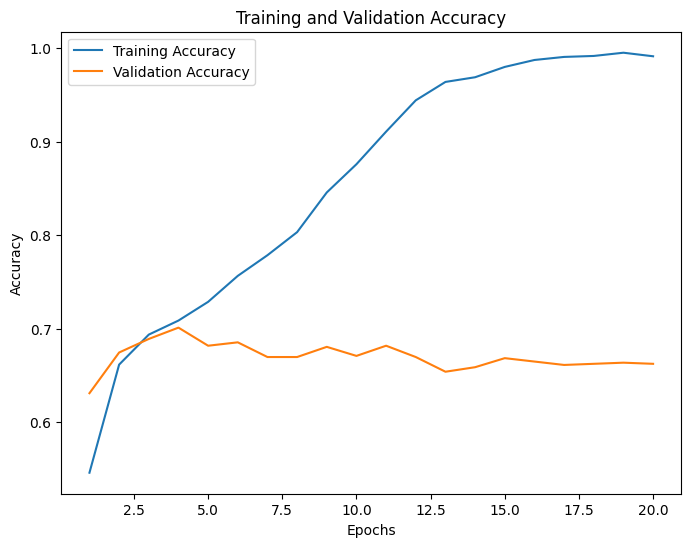

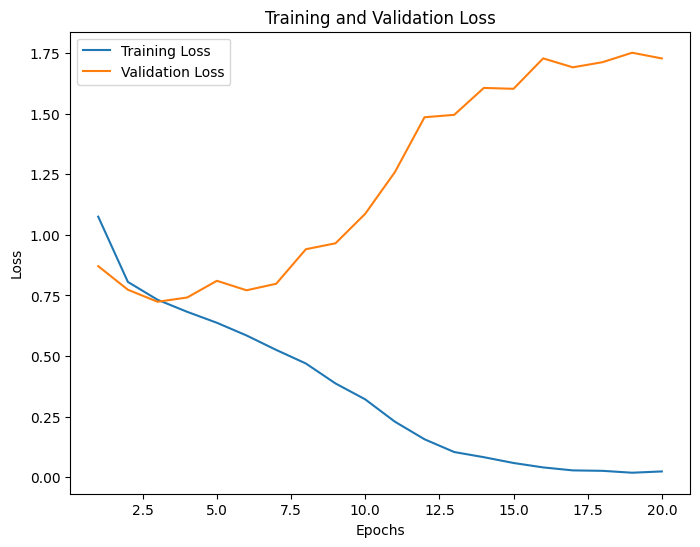

In [16]:
# Cell [16]
epochs_range = range(1, num_epochs+1)

# Accuracy Plot
plt.figure(figsize=(8,6))
plt.plot(epochs_range, [acc.cpu().numpy() for acc in train_acc_history], label='Training Accuracy')
plt.plot(epochs_range, [acc.cpu().numpy() for acc in val_acc_history], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss Plot
plt.figure(figsize=(8,6))
plt.plot(epochs_range, train_loss_history, label='Training Loss')
plt.plot(epochs_range, val_loss_history, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
